In [9]:
from tqdm import tqdm
from common.utils import Logger
import numpy as np
import operator as op
from functools import reduce
import pickle
import matplotlib.pyplot as plt
import torch


from varname import nameof


In [10]:
# figure = plt.figure(figsize = (5, 5))

# radius = 50
# n_ring = 3
# n_centroid = 8
# total_centroid = n_centroid * n_ring +1
# centroids = np.array([[0,0]])
# for ring in range(n_ring):
#     radius_ring = radius * 2 ** ring
#     angle_ring = np.array([-np.pi*(n_centroid - 1)/n_centroid + i *np.pi/(n_centroid//2) for i in range(n_centroid)]) + (np.pi/n_centroid) * (ring %2)
    
#     position_cos_ring = np.atleast_2d(radius_ring * np.cos(angle_ring)) #n
#     position_sin_ring = np.atleast_2d(radius_ring * np.sin(angle_ring)) #n
#     position_ring = np.concatenate((position_cos_ring, position_sin_ring), axis = 0).T # n,2
    
#     centroids = np.concatenate((centroids, position_ring), axis = 0) # 33, 2
    
# plt.scatter(centroids[:, 0], centroids[:, 1])
# max_range_predict = radius * 2**(n_ring-1) + radius * 2**(n_ring-2)/2
# print(max_range_predict)

In [11]:
# # design edge of voroni

# def getDistance(a, b):
#     return torch.cdist(torch.tensor(a), torch.tensor(b))

# centroid_distance = getDistance(centroids, centroids).numpy()
# centroid_edge_matrix = np.zeros(centroid_distance.shape) + np.eye(total_centroid)
# for ring in range(n_ring):
#     index_min = ring *n_centroid + 1
#     index_max = (ring + 1) * n_centroid
    
#     layer_distance = getDistance(centroids[max((ring-1) *n_centroid + 1, 0 )][np.newaxis, :], centroids[index_min][np.newaxis, :]).numpy()[0][0]
#     perimeter_distance = getDistance(centroids[index_min][np.newaxis, :], centroids[index_min+1][np.newaxis, :]).numpy()[0][0]
    
#     # print(layer_distance, perimeter_distance)
#     # print(np.sum(np.abs(centroid_ring_distance - layer_distance) < 1e-10))
#     # print(np.sum(np.abs(centroid_ring_distance - perimeter_distance) < 1e-10))
    
#     centroid_ring_distance = centroid_distance[index_min:index_max+1]
    
#     centroid_edge_matrix[index_min:index_max+1][np.abs(centroid_ring_distance - layer_distance) < 1e-10] = 1
#     centroid_edge_matrix[index_min:index_max+1][np.abs(centroid_ring_distance - perimeter_distance) < 1e-10] = 1
    

# rows, cols = np.where(centroid_edge_matrix == 1)
# edges = [edge for edge in zip(rows.tolist(), cols.tolist())]

# # draw graph
# graph = nx.Graph()

# for node in range(total_centroid):
#     graph.add_node(node)
    
# graph.add_edges_from(edges)
# nx.draw(graph, [(x,y) for x,y in centroids], node_size = 50)

In [12]:
# centroid_distance = getDistance(centroids, centroids).numpy()
# centroid_edge_matrix = np.zeros(centroid_distance.shape) + np.eye(total_centroid)
    
# layer_distance = getDistance(centroids[0][np.newaxis, :], centroids[6][np.newaxis, :]).numpy()[0][0]
# perimeter_distance = getDistance(centroids[0][np.newaxis, :], centroids[1][np.newaxis, :]).numpy()[0][0]

    
# centroid_edge_matrix[np.abs(centroid_distance - layer_distance) < 1e-10] = 1
# centroid_edge_matrix[np.abs(centroid_distance - perimeter_distance) < 1e-10] = 1
    

# rows, cols = np.where(centroid_edge_matrix == 1)
# edges = [edge for edge in zip(rows.tolist(), cols.tolist())]

# # draw graph
# graph = nx.Graph()

# for node in range(total_centroid):
#     graph.add_node(node)
    
# graph.add_edges_from(edges)
# nx.draw(graph, [(x,y) for x,y in centroids], node_size = 50)

In [13]:
n_data_file = 13#7
file_type = 'stochastic' #'cyclone'

# map_x, map_y = 20, 20
# # predict_boundary = np.array([[-15, 15], [-15, 15]])
# predict_boundary = np.array([[-200, 200], [-200, 200]])

# log_path = "../output/data/"+file_type+"/old_data/data_{}.txt"
log_path = "../output/data/"+file_type+"/data_{}.txt"

#single data
single_list = ["boundary", "concentration", "position", "water_flow_force"]
time_series_list = ["detect_total_concentration", "detect_water_flow_force", "detect_avg_concentration", "detect_source", "action", "agent_position"]

def getSingleData(logger, variable):
    data = np.array(logger.log[variable])[:, 0]
    if len(data.shape) == 1:
        return np.atleast_2d(data).T
    else: return data

def getTimeSeriesData(logger, variable):
    return np.atleast_3d(logger.log[variable])

logger = Logger()
for i_data_file in range(n_data_file):
    logger.loadLog(log_path.format(i_data_file))

In [14]:
# process input data

input_variables = ["detect_total_concentration", "detect_water_flow_force"]

def getData(getDataFunction, variables):
    logger = Logger()
    for i_data_file in range(n_data_file):
        # print(i_data_file)
        logger.loadLog(log_path.format(i_data_file))
        for (i_variable, variable) in enumerate(variables):
            data = getDataFunction(logger, variable)
            # print(data.shape)
            if i_variable == 0:
                input_data = data
            else:
                
                input_data =np.concatenate((input_data,data), axis = -1)
                
        if i_data_file == 0:
            output = input_data
        else: output = np.concatenate((output, input_data), axis = 0)
    return output
    
    
X_input = getData(getTimeSeriesData, input_variables)

In [15]:
# process heat map data
source_position = getData(getSingleData, ['position'])
source_concentration = getData(getSingleData, ['concentration'])
water_flow_force = getData(getSingleData, ['water_flow_force'])
source_detect = getData(getTimeSeriesData, ['detect_source']).squeeze()
agent_action = getData(getTimeSeriesData, ['action'])
agent_position = getData(getTimeSeriesData, ['agent_position']) #bsize, time_len, 2

In [16]:
source_detect_mask = source_detect.max(axis= 1).astype(np.bool_)
print(np.sum(source_detect_mask)/len(source_position))
np.sum(X_input[...,0]>0) / np.product(source_detect.shape)

0.7831363636363636


0.008333333333333333

In [19]:
np.sum(source_concentration>0)

22000

In [20]:
np.product(source_detect.shape)

2640000

In [17]:
np.sum(X_input[...,0]>0)/np.product(source_detect.shape)

0.11406401515151515

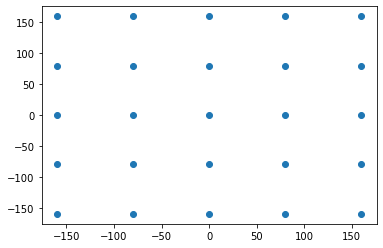

In [9]:
map_x = 5

predict_boundary = np.array([[-200, 200], [-200, 200]])
radius_ring = (predict_boundary[0,1] - predict_boundary[0,0])/map_x /2


centroids_x = np.linspace(predict_boundary[0][0] + radius_ring, predict_boundary[0][1] - radius_ring, map_x)
centroids_y = np.linspace(predict_boundary[1][0] + radius_ring, predict_boundary[1][1] - radius_ring, map_x)

X, Y = np.meshgrid(centroids_x,centroids_y)
centroids = np.concatenate((X.reshape(-1, 1), Y.reshape(-1, 1)), axis = -1)
plt.scatter(centroids[:, 0], centroids[:, 1])


max_range_predict = np.max(predict_boundary) 
total_centroid = map_x**2

In [10]:
source_pos = source_position[:, np.newaxis, :] - agent_position

distance_map = torch.cdist(torch.tensor(source_pos, dtype=float), torch.tensor(centroids, dtype=float)).numpy() # bsize, time_len, n_centroids
source_distance = torch.cdist(torch.tensor(source_pos, dtype=float), torch.tensor([[0,0]], dtype=float)).squeeze(-1).numpy() # bsize, time_len
source_inside = source_distance<=max_range_predict #bsize, time_len
source_region = np.argmin(distance_map, axis = -1) # bsize, time_len

source_region_centroid = centroids[source_region]

In [11]:
# error angle

cos_between = np.sum(source_pos * source_region_centroid, axis = -1)/(np.linalg.norm(source_pos, axis = -1) * np.linalg.norm(source_region_centroid, axis = -1))
# angle_between = np.ones(cos_between.shape) * -1
# angle_between[1-np.isnan(cos_between)] = np.arccos(cos_between[1-np.isnan(cos_between)])

error_angle = np.arccos(cos_between)
error_angle[np.isnan(error_angle) ]= -1 #bsize, time_len

<ipython-input-11-7a103eec9376>:3: RuntimeWarning: invalid value encountered in true_divide
  cos_between = np.sum(source_pos * source_region_centroid, axis = -1)/(np.linalg.norm(source_pos, axis = -1) * np.linalg.norm(source_region_centroid, axis = -1))


In [12]:
# error distance
error_distance = torch.nn.PairwiseDistance(p =2)(torch.tensor(source_pos, dtype = float).reshape(-1, 2), torch.tensor(source_region_centroid, dtype = float).reshape(-1,2)).reshape(source_pos.shape[:-1])
error_distance.shape #bsize, time_len

torch.Size([12000, 120])

In [13]:
def applyMaskGetFinal(variables, mask):
    name_list =[]
    for variable in variables:
        variable_final = variable +"_final"
        
        globals()[variable_final] = globals()[variable][mask]
        name_list.append(variable_final)

    return name_list


In [14]:
#shuffle data
shuffle_mask = np.array(range(len(source_detect)))
np.random.shuffle(shuffle_mask)

source_detect_mask = source_detect.max(axis= 1).astype(np.bool)


variables = ["source_pos", "source_region", "X_input", "source_concentration", 
             "water_flow_force", "source_inside", "distance_map", "source_detect",
             "source_distance", "agent_action", "agent_position"]

final_variables = applyMaskGetFinal(variables, shuffle_mask)

<ipython-input-14-17f2a748783f>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  source_detect_mask = source_detect.max(axis= 1).astype(np.bool)


In [15]:
file_type

'stochastic'

In [15]:
def writeToFile(data, file_path):
    with open(file_path, 'wb') as f:
        x = pickle.dump(data, f)
        
def readFile(file_path):
    with open(file_path,'rb') as f:
        data = pickle.load(f)
    return data

def writeFinalFiles(variable_names, path):
    for name in variable_names:
        new_name = name.replace("_final", "")
        variable_path = path + new_name + ".pkl"
        writeToFile(globals()[name], variable_path)
        
path = "../output/data/processedData/voroni/"+file_type+"/{}/".format(map_x)

extra_variables = ["centroids"]

final_variables += extra_variables
writeFinalFiles(final_variables, path)


(12000, 120, 25) (12000, 120, 25)
(12000, 120, 100) (12000, 120, 100)
(12000, 120, 400) (12000, 120, 400)


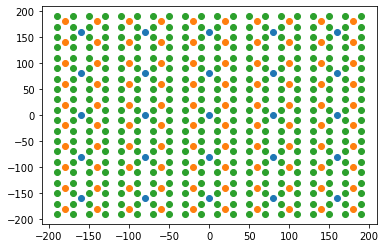

In [17]:
   
map_xs = [5, 10, 20] #[5, 10, 20]
for map_x in map_xs:
    # predict_boundary = np.array([[-10, 10], [-10, 10]])#
    predict_boundary = np.array([[-200, 200], [-200, 200]])
    radius_ring = (predict_boundary[0,1] - predict_boundary[0,0])/map_x /2


    centroids_x = np.linspace(predict_boundary[0][0] + radius_ring, predict_boundary[0][1] - radius_ring, map_x)
    centroids_y = np.linspace(predict_boundary[1][0] + radius_ring, predict_boundary[1][1] - radius_ring, map_x)

    X, Y = np.meshgrid(centroids_x,centroids_y)
    centroids = np.concatenate((X.reshape(-1, 1), Y.reshape(-1, 1)), axis = -1)
    plt.scatter(centroids[:, 0], centroids[:, 1])


    max_range_predict = np.max(predict_boundary) 
    total_centroid = map_x**2
    
    source_pos = source_position[:, np.newaxis, :] - agent_position

    distance_map = torch.cdist(torch.tensor(source_pos, dtype=float), torch.tensor(centroids, dtype=float)).numpy() # bsize, time_len, n_centroids
    source_distance = torch.cdist(torch.tensor(source_pos, dtype=float), torch.tensor([[0,0]], dtype=float)).squeeze(-1).numpy() # bsize, time_len
    source_inside = source_distance<=max_range_predict #bsize, time_len
    source_region = np.argmin(distance_map, axis = -1) # bsize, time_len

    source_region_centroid = centroids[source_region]
    
    
    #shuffle data
    shuffle_mask = np.array(range(len(source_detect)))
    np.random.shuffle(shuffle_mask)
    # shuffle_mask = shuffle_mask[:int(len(shuffle_mask) * 0.5)]
    
    variables = ["source_pos", "source_region", "X_input", "source_concentration", 
             "water_flow_force", "source_inside", "distance_map", "source_detect",
             "source_distance", "agent_action", "agent_position"]
    
    final_variables = applyMaskGetFinal(variables, shuffle_mask)
    
    print(distance_map.shape, distance_map_final.shape)
    
    path = "../output/data/processedData/voroni/"+file_type+"/{}/".format(map_x)

    extra_variables = ["centroids"]

    final_variables += extra_variables
    writeFinalFiles(final_variables, path)

In [35]:
agent_action[:2, :10]

array([[[2],
        [2],
        [2],
        [2],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]],

       [[0],
        [0],
        [1],
        [1],
        [2],
        [2],
        [2],
        [0],
        [1],
        [1]]])

In [29]:
# source_region.shape
predict_source_pos = centroids[source_region]
predict_source_pos.shape

(18000, 120, 2)

(22000, 120, 3)

In [60]:
def getDistance(A,B):
    return torch.nn.PairwiseDistance(p =2)(torch.tensor(A, dtype = float).reshape(-1, 2), torch.tensor(B, dtype = float).reshape(-1,2))

def findAngle(A, B):
    A, B = torch.tensor(A), torch.tensor(B)
    cos_between = torch.sum(A * B, axis = -1)/(torch.norm(B, dim = -1) * torch.norm(A, dim = -1))
    error_angle = torch.arccos(cos_between)
    # error_angle[error_angle > np.pi/2] = np.pi - error_angle[error_angle > np.pi/2] 
    error_angle[torch.isnan(error_angle) ]= -1 #bsize, time_len
    return error_angle

error_angle = findAngle(predict_source_pos, source_pos)
# distance_agent_source = getDistance(source_pos, agent_position).reshape(source_pos.shape[:-1])

distance_agent_source = torch.norm(torch.tensor(source_pos), dim = -1)
error_distance = getDistance(predict_source_pos, source_pos).reshape(source_pos.shape[:-1])


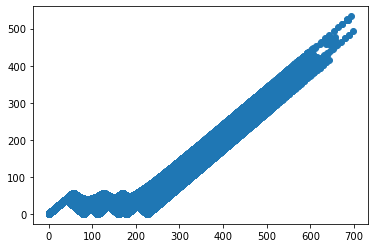

In [61]:
plt.scatter(distance_agent_source.reshape(-1), error_distance.reshape(-1))

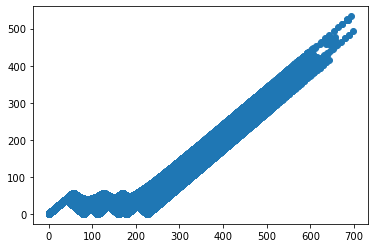

In [62]:
plt.scatter(distance_agent_source.reshape(-1), distance_map.min(-1).reshape(-1))

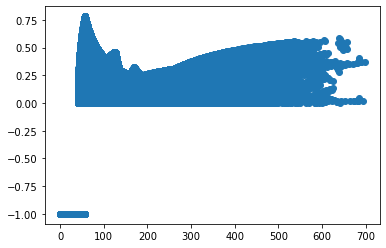

In [63]:
plt.scatter(distance_agent_source.reshape(-1), error_angle.reshape(-1))

In [45]:
mask = (distance_agent_source>100) * (error_angle == -1)
torch.where(mask.reshape(-1))

(tensor([     18,      32,      33,  ..., 2159791, 2159849, 2159873]),)

In [47]:
source_pos.reshape(-1,2)[18]

array([  2.66444632, -36.25581493])

In [48]:
agent_position.reshape(-1,2)[18]

array([-70,  40])

In [49]:
distance_agent_source.reshape(-1)[18]

tensor(105.3331, dtype=torch.float64)

In [50]:
error_angle.reshape(-1)[18]

tensor(-1., dtype=torch.float64)

In [51]:
predict_source_pos.reshape(-1)[18]

0.0

In [54]:
distance_map.reshape(-1, 25)[18].reshape(5,5)

array([[204.38284036, 148.81543611, 123.77286703, 145.9226206 ,
        200.16767919],
       [168.4436874 ,  93.52520737,  43.8252553 ,  88.85010743,
        163.30349102],
       [166.65595162,  90.26569005,  36.35358841,  85.41236432,
        161.45885101],
       [199.93783184, 142.64930841, 116.2863439 , 139.62880207,
        195.62691777],
       [254.90403486, 212.95482051, 196.27390088, 210.94343497,
        251.53691845]])